In [1]:
pip install sec-api

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [40]:
from sec_api import ExtractorApi  # https://pypi.org/project/sec-api/

# Initialize API
extractorApi = ExtractorApi("02f072c5d4ed3c15b3a35b514fe0e479937075da99d4d535802c74dfddb672aa")

# Hershey 10-K filing URLs
filing_urls = [
    "https://www.sec.gov/Archives/edgar/data/47111/000004711121000007/hsy-20201231.htm",
    "https://www.sec.gov/Archives/edgar/data/47111/000004711122000017/hsy-20211231.htm",
    "https://www.sec.gov/Archives/edgar/data/47111/000004711123000012/hsy-20221231.htm",
    "https://www.sec.gov/Archives/edgar/data/47111/000004711124000009/hsy-20231231.htm",
    "https://www.sec.gov/Archives/edgar/data/47111/000004711125000014/hsy-20241231.htm"
]

# Loop through each filing to extract Section 7 (MD&A)
for filing_url in filing_urls:
    try:
        year = filing_url.split("-")[-1].split(".")[0]
        print(f"\n📄 Section 7 - MD&A for {year}:")

        # Get Section 7 text (standardized format)
        section_text = extractorApi.get_section(filing_url, "7", "text")
        print(section_text[:1000])  # Preview the first 1000 characters

        # Optional: Get raw HTML
        # section_html = extractorApi.get_section(filing_url, "7", "html")
        # print(section_html[:1000])

    except Exception as e:
        print(f"❌ Error retrieving Section 7 for {filing_url}: {e}")



📄 Section 7 - MD&A for 20201231:
 Item 7. MANAGEMENT&#8217;S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS 

This Management's Discussion and Analysis (&#8220;MD&#38;A&#8221;) is intended to provide an understanding of Hershey's financial condition, results of operations and cash flows by focusing on changes in certain key measures from year to year. The MD&#38;A should be read in conjunction with our Consolidated Financial Statements and accompanying Notes included in Item 8 of this Annual Report on Form 10-K. This discussion contains forward-looking statements that involve risks and uncertainties. Our actual results could differ materially from those anticipated in these forward-looking statements as a result of various factors, including those discussed elsewhere in this Annual Report on Form 10-K, particularly in Item 1A. &#8220;Risk Factors.&#8221; 

The MD&#38;A is organized in the following sections: 

&#8226; Business Model and Growth Strategy 

&#82

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


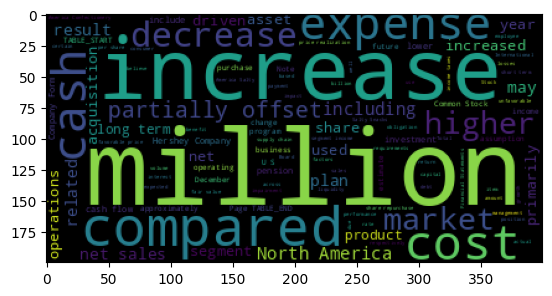

In [42]:
import pandas as pd
import numpy as np
!pip install wordcloud

#for plotting images & adjusting colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

wc = WordCloud().generate(section_text)
plt.imshow(wc)

In [43]:

%pip install nltk

import nltk
nltk.download('vader_lexicon')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [44]:
# import libraries
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [45]:
#Create a Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()
#Analyze section_text
scores = analyzer.polarity_scores(section_text)

print(scores)
#the compound key is a normalized score that ranges from -1(most negative) to 1(most positive)

{'neg': 0.024, 'neu': 0.867, 'pos': 0.108, 'compound': 1.0}


In [46]:
#We can also check which score is the highest and use that to classify the text as positive, negative, or neutral.
if scores['compound'] >= 0.5:
    print("Positive")
elif scores['compound'] >-0.5:
    print("Neutral")
else:
    print("Negative")

Positive


In [47]:
%pip install tf-keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [48]:
%pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [49]:
from transformers import pipeline

In [50]:
if section_text:
    # Load FinBERT model
    finbert = pipeline("text-classification", model="ProsusAI/finbert")

    # Split text into chunks (FinBERT has a 512-token limit)
    sentences = section_text.split(". ")
    chunk = ""
    sentiment_results = []

    for sentence in sentences:
        if len(chunk) + len(sentence) < 512:
            chunk += sentence + ". "
        else:
            sentiment_results.extend(finbert(chunk[:512]))  # Process chunk
            chunk = sentence + ". "

    # Process the last chunk if any
    if chunk:
        sentiment_results.extend(finbert(chunk[:512]))


Device set to use cpu


In [51]:
from collections import Counter


Sentiment Distribution: {'neutral': 54.04, 'positive': 29.8, 'negative': 16.16}


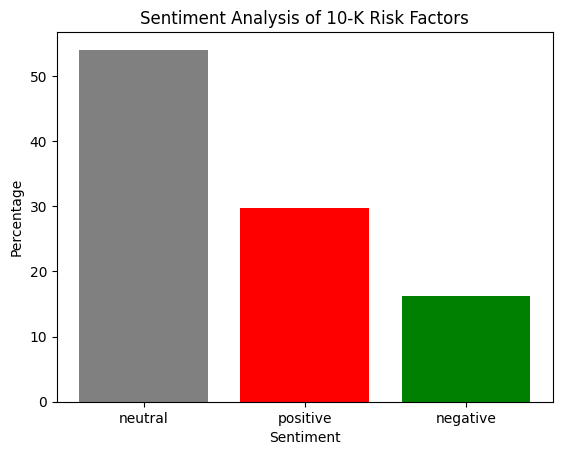

In [52]:
 # Process the last chunk if any
if chunk:
    sentiment_results.extend(finbert(chunk[:512]))

    # Aggregate Sentiments
    labels = [res['label'] for res in sentiment_results]
    count = Counter(labels)
    total = len(sentiment_results)
    percentage = {label: round((count[label] / total) * 100, 2) for label in count}

    # Print sentiment distribution
    print("Sentiment Distribution:", percentage)

    # Plot sentiment results
    plt.bar(percentage.keys(), percentage.values(), color=['gray', 'red', 'green'])
    plt.xlabel("Sentiment")
    plt.ylabel("Percentage")
    plt.title("Sentiment Analysis of 10-K Risk Factors")
    plt.show()

else:
    print("Section 7 not found.")